In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

21760


In [5]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [6]:
os.mkdir(temp_work_dir)

In [7]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [10]:
move_motors = ['hkb_4']

In [11]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [12]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

0.00010969454732514583


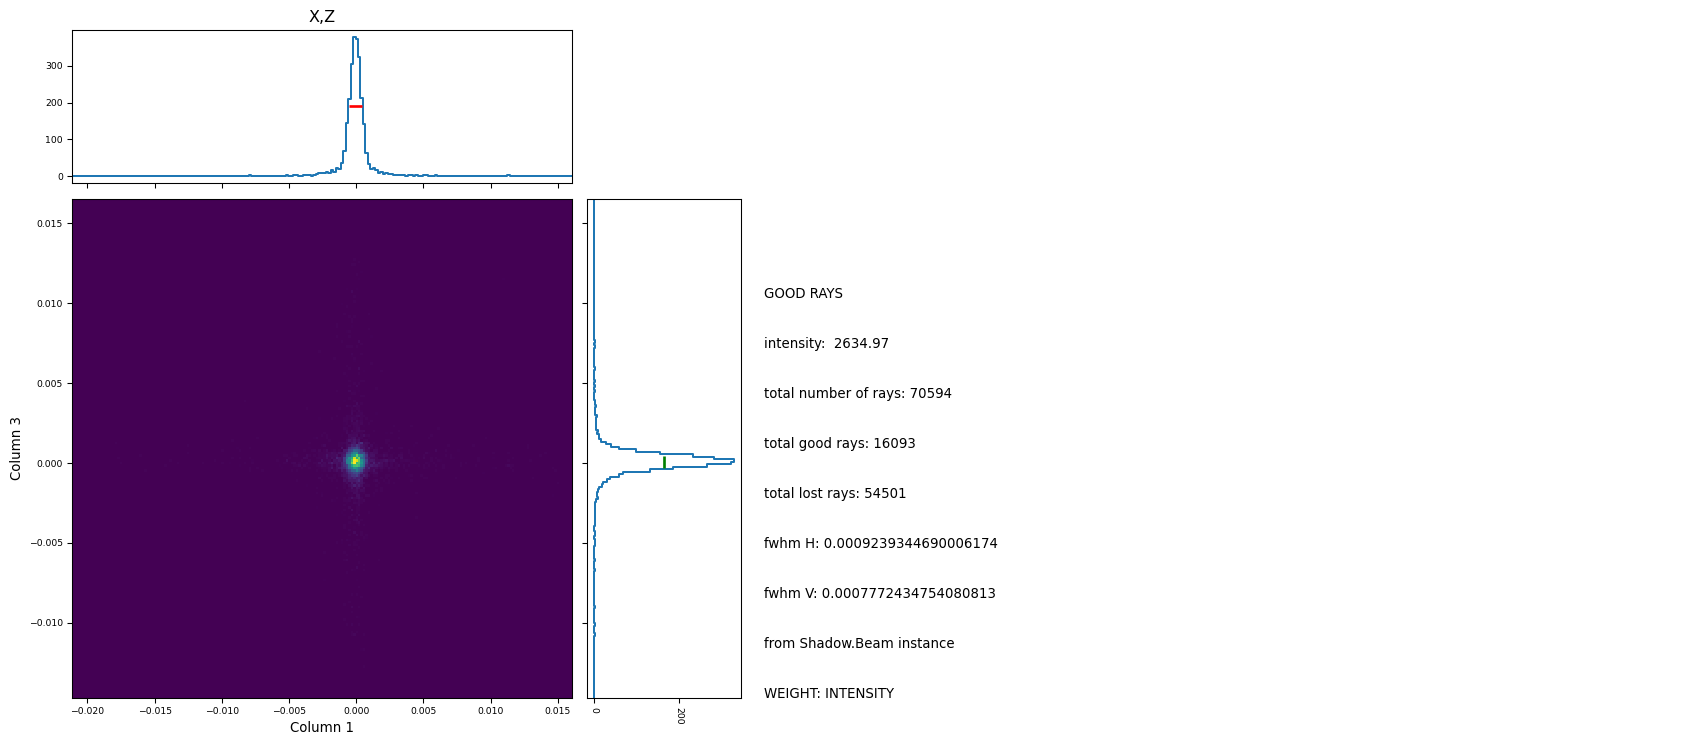

In [13]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [14]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0.]


In [17]:
%%time
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []

min_trans = -0.14
max_trans = 0.14

for outer in tqdm(range(5)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=False, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')

  0%|          | 0/10 [00:00<?, ?it/s]

Initial motor positions are [-0.0069699]
motors ['hkb_4'] trans [0.] current loss 0.006901908345207665
Initial loss is 0.006901908345207665
motors ['hkb_4'] trans [-0.03464439] current loss 0.04150907120259532
motors ['hkb_4'] trans [-0.0363766] current loss 0.04323527437668375
motors ['hkb_4'] trans [-0.03291217] current loss 0.03978173015065271
motors ['hkb_4'] trans [-0.02944773] current loss 0.03632460919081154
motors ['hkb_4'] trans [-0.02425107] current loss 0.03114277969520624
motors ['hkb_4'] trans [-0.01385775] current loss 0.020781466369892306
motors ['hkb_4'] trans [0.00173222] current loss 0.005168273946828925
motors ['hkb_4'] trans [0.03291217] current loss 0.025879404947300996
motors ['hkb_4'] trans [0.01732219] current loss 0.010401894893630385
motors ['hkb_4'] trans [0.00562971] current loss 0.0012709233982076513
motors ['hkb_4'] trans [0.00952721] current loss 0.0026294664298905134
motors ['hkb_4'] trans [0.00660409] current loss 0.00030513982668720476
motors ['hkb_4']

 10%|█         | 1/10 [00:33<05:01, 33.54s/it]

Test 0 success True
Initial motor positions are [0.12409894]
motors ['hkb_4'] trans [0.] current loss 0.12342842811211868
Initial loss is 0.12342842811211868
motors ['hkb_4'] trans [-0.12342592] current loss 0.0007509244283211971
motors ['hkb_4'] trans [-0.12959722] current loss 0.005429146165424989
motors ['hkb_4'] trans [-0.11725463] current loss 0.006904912402639262
motors ['hkb_4'] trans [-0.12496875] current loss 0.0008020969481435715
motors ['hkb_4'] trans [-0.1218831] current loss 0.002288932852903635
motors ['hkb_4'] trans [-0.12381163] current loss 0.0003703117106353595
motors ['hkb_4'] trans [-0.12419733] current loss 8.864520287195073e-05
motors ['hkb_4'] trans [-0.12496875] current loss 0.0008020969481436173
motors ['hkb_4'] trans [-0.12458304] current loss 0.00042012463689400197
motors ['hkb_4'] trans [-0.12410091] current loss 0.00011070603516776411


 20%|██        | 2/10 [00:56<03:40, 27.53s/it]

Test 1 success True
Initial motor positions are [-0.10810223]
motors ['hkb_4'] trans [0.] current loss 0.10789262416238797
Initial loss is 0.10789262416238797
motors ['hkb_4'] trans [0.07451558] current loss 0.0335023963228601
motors ['hkb_4'] trans [0.07824136] current loss 0.02978570318527835
motors ['hkb_4'] trans [0.08196714] current loss 0.02606939802434086
motors ['hkb_4'] trans [0.08941869] current loss 0.018637790614925025
motors ['hkb_4'] trans [0.10059603] current loss 0.007438003435203465
motors ['hkb_4'] trans [0.1229507] current loss 0.014882262200034045
motors ['hkb_4'] trans [0.11177337] current loss 0.003741360433740537
motors ['hkb_4'] trans [0.13412804] current loss 0.025962993133639728
motors ['hkb_4'] trans [0.1229507] current loss 0.014882262200034045
motors ['hkb_4'] trans [0.10897903] current loss 0.0009539848866632615
motors ['hkb_4'] trans [0.1061847] current loss 0.0018488775858211727
motors ['hkb_4'] trans [0.10828045] current loss 0.00026540566486099473
moto

 30%|███       | 3/10 [01:30<03:31, 30.20s/it]

Test 2 success True
Initial motor positions are [-0.07128161]
motors ['hkb_4'] trans [0.] current loss 0.07111782085166127
Initial loss is 0.07111782085166127
motors ['hkb_4'] trans [0.11358802] current loss 0.04221485161560057
motors ['hkb_4'] trans [0.11926742] current loss 0.04788542695126726
motors ['hkb_4'] trans [0.10790862] current loss 0.03654652572253391
motors ['hkb_4'] trans [0.09654981] current loss 0.02521131068367303
motors ['hkb_4'] trans [0.07951161] current loss 0.008288115299086468
motors ['hkb_4'] trans [0.04543521] current loss 0.025783219472620952
motors ['hkb_4'] trans [0.06247341] current loss 0.008741183223278612
motors ['hkb_4'] trans [0.07525206] current loss 0.004040378382779867
motors ['hkb_4'] trans [0.07099251] current loss 0.00023179346932981752
motors ['hkb_4'] trans [0.06247341] current loss 0.008741183223278612
motors ['hkb_4'] trans [0.06673296] current loss 0.004479163319958486
motors ['hkb_4'] trans [0.0720574] current loss 0.0008537047400415968
mot

 40%|████      | 4/10 [02:03<03:07, 31.28s/it]

Test 3 success True
Initial motor positions are [0.0464812]
motors ['hkb_4'] trans [0.] current loss 0.046381834625847405
Initial loss is 0.046381834625847405
motors ['hkb_4'] trans [0.04611725] current loss 0.09234691324820782
motors ['hkb_4'] trans [0.04842311] current loss 0.09464367498859577
motors ['hkb_4'] trans [0.04381139] current loss 0.09004954028031081
motors ['hkb_4'] trans [0.03919966] current loss 0.08545438428373975
motors ['hkb_4'] trans [0.03228208] current loss 0.07856116633307679
motors ['hkb_4'] trans [0.0184469] current loss 0.06477461741430891
motors ['hkb_4'] trans [-0.00230586] current loss 0.04408112718776388
motors ['hkb_4'] trans [-0.04381139] current loss 0.002741696798878815
motors ['hkb_4'] trans [-0.10606968] current loss 0.05944332420982197
motors ['hkb_4'] trans [-0.05937596] current loss 0.012831305564266662
motors ['hkb_4'] trans [-0.02824682] current loss 0.018255827919343832
motors ['hkb_4'] trans [-0.04770253] current loss 0.0011522082651995015
mot

 50%|█████     | 5/10 [02:38<02:43, 32.77s/it]

Test 4 success True
Initial motor positions are [-0.0011737]
motors ['hkb_4'] trans [0.] current loss 0.001104439322063609
Initial loss is 0.001104439322063609
motors ['hkb_4'] trans [0.12167779] current loss 0.12009409862284808
motors ['hkb_4'] trans [0.12776168] current loss 0.12588855155397577
motors ['hkb_4'] trans [0.1155939] current loss 0.11396948937161032
motors ['hkb_4'] trans [0.10342612] current loss 0.10187812037643117
motors ['hkb_4'] trans [0.08517445] current loss 0.08378112233034338
motors ['hkb_4'] trans [0.04867112] current loss 0.04739879439395339
motors ['hkb_4'] trans [-0.00608389] current loss 0.0071899032954701
motors ['hkb_4'] trans [-0.1155939] current loss 0.11655445577603982
motors ['hkb_4'] trans [-0.0608389] current loss 0.061862426293418676
motors ['hkb_4'] trans [0.00760486] current loss 0.00649303431104732
motors ['hkb_4'] trans [0.02129361] current loss 0.020130874635292385
motors ['hkb_4'] trans [0.00418267] current loss 0.003080537099509031
motors ['h

 60%|██████    | 6/10 [03:20<02:24, 36.02s/it]

Test 5 success True
Initial motor positions are [-0.13803267]
motors ['hkb_4'] trans [0.] current loss 0.1378364093661224
Initial loss is 0.1378364093661224
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.13304169] current loss inf
motors ['hkb_4'] trans [-0.12037105] current loss inf
motors ['hkb_4'] trans [-0.1282902] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf


/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.12670637] current loss inf
motors ['hkb_4'] trans [-0.1

 70%|███████   | 7/10 [04:25<02:15, 45.32s/it]

Test 6 success True
Initial motor positions are [-0.02375673]
motors ['hkb_4'] trans [0.] current loss 0.023698941398540556
Initial loss is 0.023698941398540556
motors ['hkb_4'] trans [-0.04929474] current loss 0.07288478567844796
motors ['hkb_4'] trans [-0.05175947] current loss 0.07534732156647803
motors ['hkb_4'] trans [-0.04683] current loss 0.07042452684322922
motors ['hkb_4'] trans [-0.04190053] current loss 0.06550150787832482
motors ['hkb_4'] trans [-0.03450631] current loss 0.058120190599611654
motors ['hkb_4'] trans [-0.01971789] current loss 0.043362359099163125
motors ['hkb_4'] trans [0.00246474] current loss 0.021243484188187403
motors ['hkb_4'] trans [0.04683] current loss 0.023068620419930526
motors ['hkb_4'] trans [0.02464737] current loss 0.0009675958750006713
motors ['hkb_4'] trans [0.06901263] current loss 0.045159362868094736
motors ['hkb_4'] trans [0.04683] current loss 0.023068620419930526
motors ['hkb_4'] trans [0.01910171] current loss 0.004586129751332205
motor

 80%|████████  | 8/10 [05:01<01:24, 42.24s/it]

Test 7 success True
Initial motor positions are [-0.1256064]
motors ['hkb_4'] trans [0.] current loss 0.12533948427356725
Initial loss is 0.12533948427356725
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.11841753] current loss inf
motors ['hkb_4'] trans [-0.10713967] current loss inf
motors ['hkb_4'] trans [-0.11418834] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current loss inf
motors ['hkb_4'] trans [-0.1127786] current 

 90%|█████████ | 9/10 [06:08<00:50, 50.18s/it]

Test 8 success True
Initial motor positions are [-0.09766528]
motors ['hkb_4'] trans [0.] current loss 0.09746796167135456
Initial loss is 0.09746796167135456
motors ['hkb_4'] trans [0.11317173] current loss 0.015537698443410464
motors ['hkb_4'] trans [0.11883032] current loss 0.021175018188460876
motors ['hkb_4'] trans [0.10751314] current loss 0.009901306599482238
motors ['hkb_4'] trans [0.09619597] current loss 0.001400053284794719
motors ['hkb_4'] trans [0.07922021] current loss 0.018398617436726297
motors ['hkb_4'] trans [0.10043991] current loss 0.0028468502606677397
motors ['hkb_4'] trans [0.09195203] current loss 0.005644588160960536
motors ['hkb_4'] trans [0.09725696] current loss 0.00034618003039603613
motors ['hkb_4'] trans [0.09831794] current loss 0.0007308253198571805
motors ['hkb_4'] trans [0.0975222] current loss 0.00010954676664129322
motors ['hkb_4'] trans [0.09778745] current loss 0.00021276878494389702
motors ['hkb_4'] trans [0.09758851] current loss 8.5016799865077

100%|██████████| 10/10 [06:35<00:00, 39.55s/it]

Test 9 success True


In [18]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [19]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [20]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [21]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

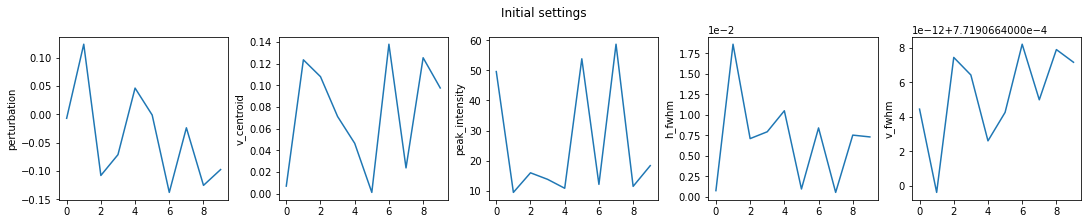

In [25]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_centroids)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

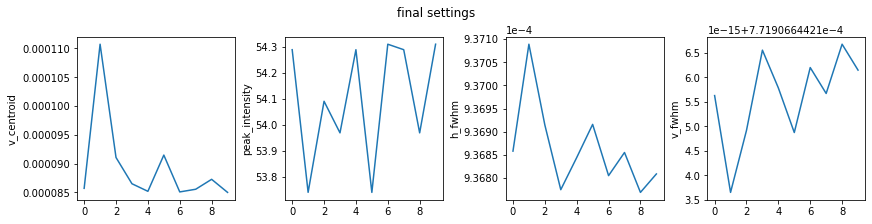

In [26]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_centroids)
axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

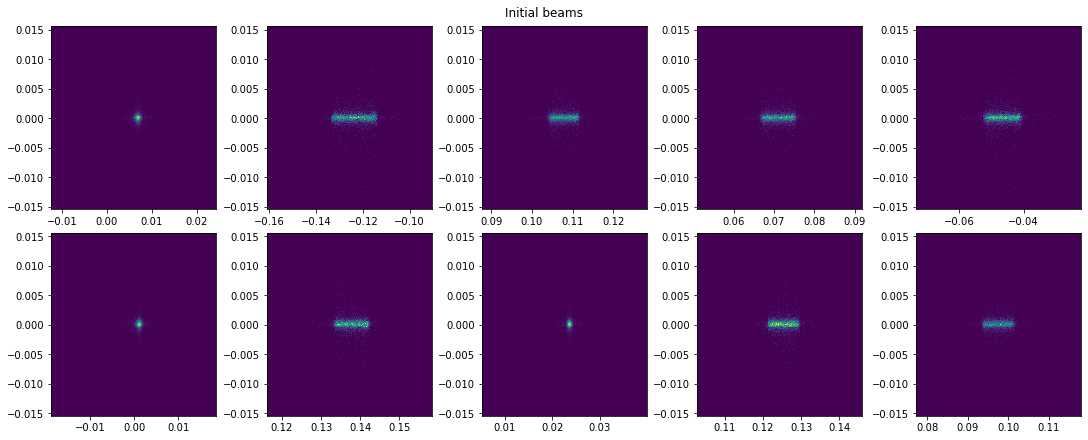

In [27]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

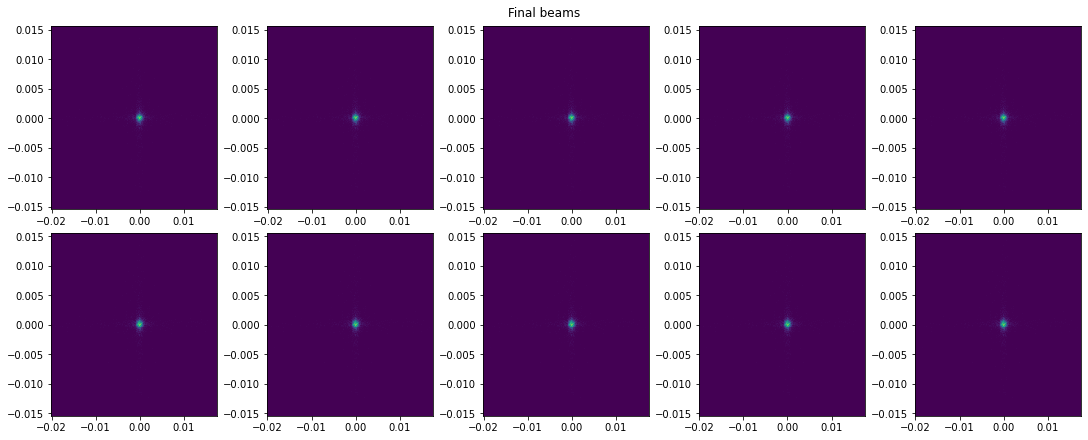

In [28]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [29]:
clean_up()

In [30]:
shutil.rmtree(temp_work_dir)